In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_india=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/India_train.csv')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline
from yellowbrick.regressor import ResidualsPlot
class BaselineScore():
    def __init__ (self,x,y):
        self.x=x
        self.y=y
        self.algos=[LinearRegression(),linear_model.Lasso(alpha=0.1),linear_model.BayesianRidge(),RandomForestRegressor(),XGBRegressor()]
        polyreg_scaled=make_pipeline(PolynomialFeatures(2),StandardScaler(),LinearRegression())
        rfr_scaled=make_pipeline(StandardScaler(),RandomForestRegressor())
        xgbr_scaled=make_pipeline(StandardScaler(),XGBRegressor())
        self.piplines=[polyreg_scaled,rfr_scaled,xgbr_scaled]
    def get_results(self,ts,flag):
        x_train,x_test,y_train,y_test=train_test_split(self.x,self.y,test_size=ts)
        for algo in self.algos:
            algo.fit(x_train,y_train)
            pr=algo.predict(x_test)
            pr2=[]
            if(flag):
                for i in pr:
                    #pr2.append((np.exp(i)-10))
                    pr2.append((np.power(i,3)))
                sc=np.sqrt(mean_squared_error(pr2,y_test))
                print("for algorithm {0},mse is:{1}".format(algo,sc))
                residuals=y_test-pr2
                sns.distplot(residuals,bins=30)
                plt.xlabel('Residuals')
                plt.show()
            else:
                sc=np.sqrt(mean_squared_error(pr,y_test))
                print("for algorithm {0},mse is:{1}".format(algo,sc))
                residuals=y_test-pr
                sns.distplot(residuals,bins=30)
                plt.xlabel('Residuals')
                plt.show()
        for pipe in self.piplines:
            pipe.fit(x_train,y_train)
            ps=pipe.predict(x_test)
            ps2=[]
            if(flag):
                for i in ps:
                    #ps2.append((np.exp(i)-10))
                    ps2.append(np.power(i,3))
                sc=np.sqrt(mean_squared_error(ps2,y_test))
                print("for pipeline {0},mse is:{1}".format(pipe,sc))
            else:
                sc=np.sqrt(mean_squared_error(ps,y_test))
                print("for pipeline {0},mse is:{1}".format(pipe,sc))
        return 
    def get_predictions(self,x_test):
        results=[]
        for pipe in self.piplines:
            results.append(pipe.predict(x_test))
        return results
    def get_residuals(self,ts):
        x_train,x_test,y_train,y_test=train_test_split(self.x,self.y,test_size=ts)
        for pipe in self.piplines:
            visualizer=ResidualsPlot(pipe)
            visualizer.fit(x_train,y_train)
            visualizer.score(x_test,y_test)
            visualizer.show()


In [6]:
def fill_null(data):
    data_copy=data.copy()
    data_copy.drop(columns=['State Name','Dist Name'],inplace=True)
    data_copy=data_copy.interpolate(method='linear',limit_direction='forward')
    data_copy=data_copy.fillna(0)
    return data_copy

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
ssl=StandardScaler()
def get_with_importance(data):
    data_copy=data.copy()
    x=data_copy.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data_copy['COTTON YIELD (Kg per ha)']
    x=ssl.fit_transform(x)
    model=XGBRegressor()
    model.fit(x,y)
    feat_imp=model.feature_importances_
    return feat_imp


In [8]:
data_train=fill_null(data_india)


In [9]:
fimp=get_with_importance(data_train)

In [10]:
fimp

array([0.00060823, 0.00217885, 0.04043036, 0.00636663, 0.00027363,
       0.0005468 , 0.0007855 , 0.0366041 , 0.00302534, 0.00429405,
       0.00025798, 0.00076195, 0.00537841, 0.00858894, 0.00019062,
       0.00166225, 0.00213034, 0.0025512 , 0.00261714, 0.0010737 ,
       0.00078699, 0.00081261, 0.00333022, 0.02131897, 0.00524836,
       0.00041397, 0.0001789 , 0.00391626, 0.00154369, 0.01115047,
       0.00915792, 0.00670119, 0.00428831, 0.00255065, 0.00321035,
       0.00096184, 0.00278026, 0.06554646, 0.00233581, 0.00059111,
       0.04512225, 0.0006475 , 0.00039975, 0.00023413, 0.00370999,
       0.01115416, 0.00080449, 0.16067761, 0.00017578, 0.00020157,
       0.02424767, 0.00028328, 0.00302966, 0.00785382, 0.00039307,
       0.01643576, 0.00173244, 0.01645724, 0.00108383, 0.00421572,
       0.00076741, 0.0050153 , 0.00456885, 0.00258237, 0.00170686,
       0.00465888, 0.00373652, 0.00118243, 0.00133359, 0.00820961,
       0.01445619, 0.00040459, 0.00122161, 0.00205401, 0.01523

In [9]:
def multiply_with_importance(data,fimp):
    data_copy=data.copy()
    cols=['Year','COTTON YIELD (Kg per ha)']
    for i,j in zip(fimp,data_copy.columns):
        if j not in cols:
            data_copy[j]=data_copy[j]*i*1000
    return data_copy


In [11]:
cols_to_add=['Year', 'COTTON AREA (1000 ha)', 'COTTON PRODUCTION (1000 tons)',
       'TOTAL AREA (1000 ha)', 'FOREST AREA (1000 ha)','COTTON YIELD (Kg per ha)',
       'BARREN AND UNCULTIVABLE LAND AREA (1000 ha)',
       'LAND PUT TO NONAGRICULTURAL USE AREA (1000 ha)',
       'CULTIVABLE WASTE LAND AREA (1000 ha)',
       'PERMANENT PASTURES AREA (1000 ha)', 'OTHER FALLOW AREA (1000 ha)',
       'CURRENT FALLOW AREA (1000 ha)', 'NET CROPPED AREA (1000 ha)',
       'GROSS CROPPED AREA (1000 ha)', 'CROPING INTENSITY (Percent)',
       'NITROGEN CONSUMPTION (tons)', 'NITROGEN SHARE IN NPK (Percent)',
       'NITROGEN PER HA OF NCA (Kg per ha)',
       'NITROGEN PER HA OF GCA (Kg per ha)', 'PHOSPHATE CONSUMPTION (tons)',
       'PHOSPHATE SHARE IN NPK (Percent)',
       'PHOSPHATE PER HA OF NCA (Kg per ha)',
       'PHOSPHATE PER HA OF GCA (Kg per ha)', 'POTASH CONSUMPTION (tons)',
       'POTASH SHARE IN NPK (Percent)', 'POTASH PER HA OF NCA (Kg per ha)',
       'POTASH PER HA OF GCA (Kg per ha)', 'TOTAL CONSUMPTION (tons)',
       'TOTAL PER HA OF NCA (Kg per ha)', 'TOTAL PER HA OF GCA (Kg per ha)','val_sum4','val_sum16','val_sum28','val_sum40','val_sum51','val_sum63']

In [12]:
important_cols=[]
for i,j in zip(fimp,data_train.columns):
    if(i>=0.001 and j!='COTTON YIELD (Kg per ha)'):
        important_cols.append(j)
        print(i,j)

0.0021788452 COTTON AREA (1000 ha)
0.04043036 COTTON PRODUCTION (1000 tons)
0.0366041 APRIL PERCIPITATION (Millimeters)
0.0030253434 MAY PERCIPITATION (Millimeters)
0.004294051 JUNE PERCIPITATION (Millimeters)
0.005378406 SEPTEMBER PERCIPITATION (Millimeters)
0.00858894 OCTOBER PERCIPITATION (Millimeters)
0.001662245 DECEMBER PERCIPITATION (Millimeters)
0.00213034 JANUARY MINIMUM (Centigrate)
0.002551196 FEBRUARY MINIMUM (Centigrate)
0.0026171359 MARCH MINIMUM (Centigrate)
0.0010737008 APRIL MINIMUM (Centigrate)
0.003330222 JULY MINIMUM (Centigrate)
0.02131897 AUGUST MINIMUM (Centigrate)
0.00524836 SEPTEMBER MINIMUM (Centigrate)
0.003916265 DECEMBER MINIMUM (Centigrate)
0.0015436879 JANUARY MAXIMUM (Centigrate)
0.011150471 FEBRUARY MAXIMUM (Centigrate)
0.009157924 MARCH MAXIMUM (Centigrate)
0.0067011854 APRIL MAXIMUM (Centigrate)
0.004288305 MAY MAXIMUM (Centigrate)
0.0025506502 JUNE MAXIMUM (Centigrate)
0.0032103504 JULY MAXIMUM (Centigrate)
0.0027802568 SEPTEMBER MAXIMUM (Centigrate)

In [114]:
important_cols.append('COTTON YIELD (Kg per ha)')
important_cols=data_train.columns

In [115]:
def get_scores_for_data(data,flag):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    s=BaselineScore(x,y)
    s.get_results(0.2,flag)
    s.get_residuals(0.2)


In [116]:
def get_residual_plots(data):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    s=BaselineScore(x,y)
    s.get_residuals(0.2)

In [117]:
cols_to_norm=['COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)','MAY PERCIPITATION (Millimeters)','OCTOBER PERCIPITATION (Millimeters)','DECEMBER PERCIPITATION (Millimeters)','JUNE WATER DEFICIT (Millimeters)','AUGUST WATER DEFICIT (Millimeters)','MAY ACTUAL (Millimeters)','FOREST AREA (1000 ha)','BARREN AND UNCULTIVABLE LAND AREA (1000 ha)','CULTIVABLE WASTE LAND AREA (1000 ha)','OTHER FALLOW AREA (1000 ha)','NITROGEN CONSUMPTION (tons)','POTASH CONSUMPTION (tons)','COTTON YIELD (Kg per ha)']
from sklearn.preprocessing import FunctionTransformer
transformer=FunctionTransformer(np.cbrt)
data_cbrt=data_train.copy()
data_cbrt=data_cbrt.loc[:,important_cols]
data_cbrt[cols_to_norm]=transformer.transform(data_cbrt[cols_to_norm])

In [118]:
def transforms(var):
    return np.log(10+var)
data_norm=data_train.copy()
data_norm=data_norm.loc[:,important_cols]
data_norm['COTTON YIELD (Kg per ha)']=data_norm['COTTON YIELD (Kg per ha)'].apply(transforms)

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='COTTON YIELD (Kg per ha)'>

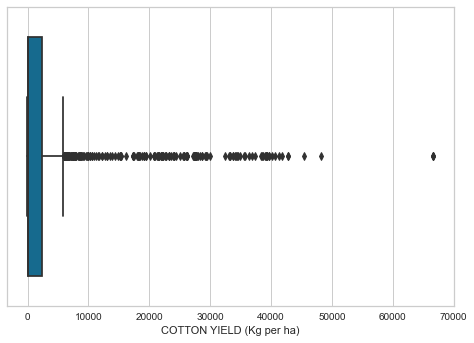

In [119]:
sns.boxplot(data_train['COTTON YIELD (Kg per ha)'])

In [120]:
from scipy import stats
z=np.abs(stats.zscore(data_train['COTTON YIELD (Kg per ha)']))
print(z)

0       0.392294
1       0.285255
2       0.612747
3       0.616812
4       0.195606
          ...   
4700    0.392294
4701    0.392294
4702    0.392294
4703    0.392294
4704    0.392294
Name: COTTON YIELD (Kg per ha), Length: 4705, dtype: float64


In [121]:
outliers=np.where(z>2)[0]

In [122]:
print(data_norm.shape)
print(data_train.shape)

(4705, 101)
(4705, 101)


for algorithm LinearRegression(),mse is:2960.9870529322657


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


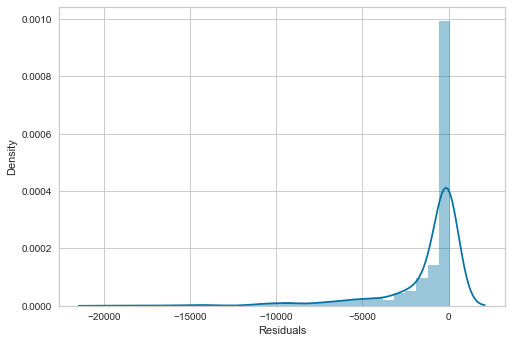

for algorithm Lasso(alpha=0.1),mse is:2853.101249865623


c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e+03, tolerance: 2.344e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


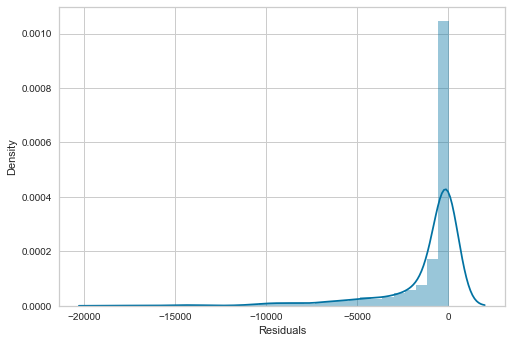

for algorithm BayesianRidge(),mse is:2800.403375679436


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


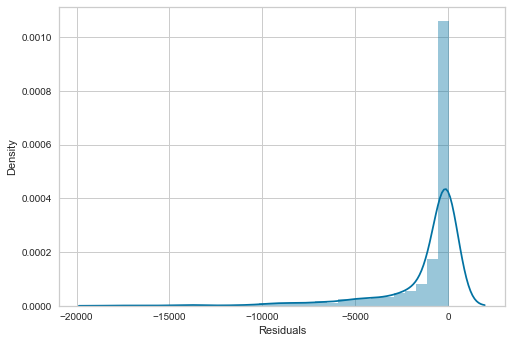

for algorithm RandomForestRegressor(),mse is:3552.848893350728


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


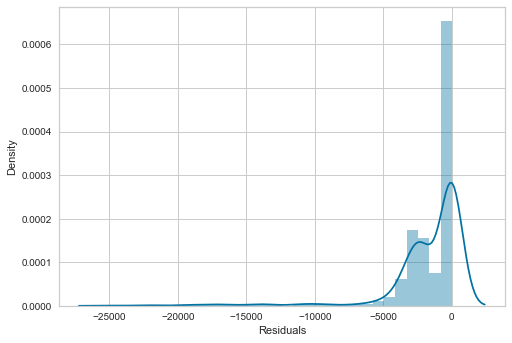

for algorithm XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...),mse is:4581.317924148662


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


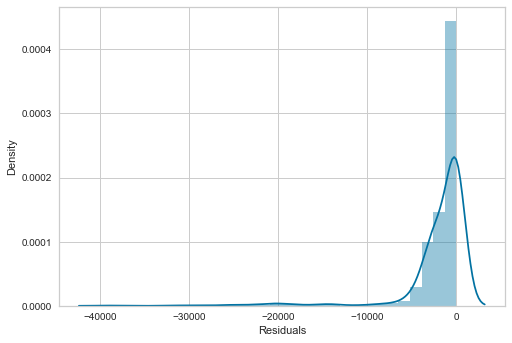

for pipeline Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]),mse is:55706.23685940259
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]),mse is:3580.7554930347055
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                 

c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


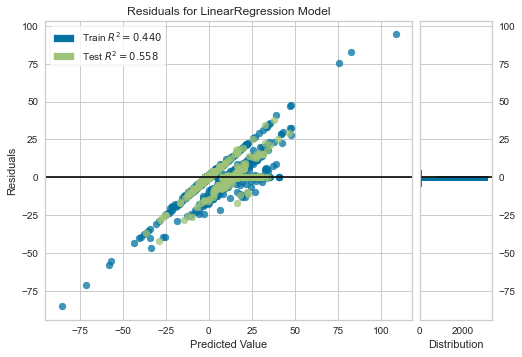

c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


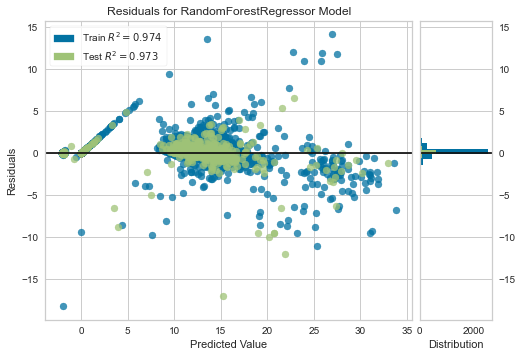

c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


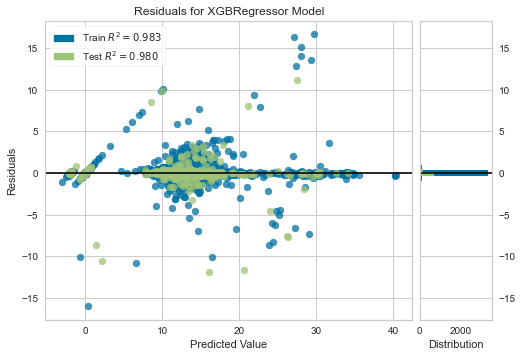

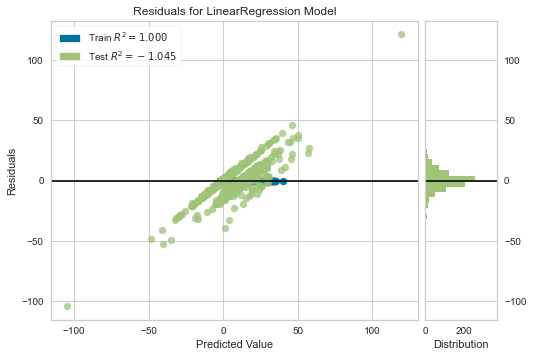

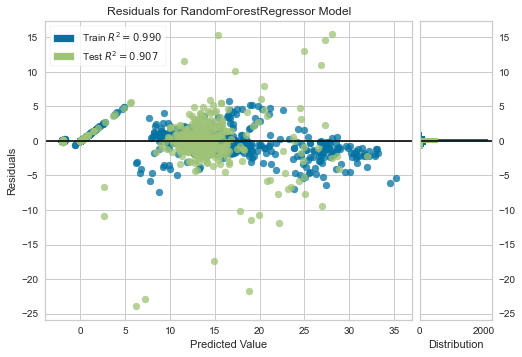

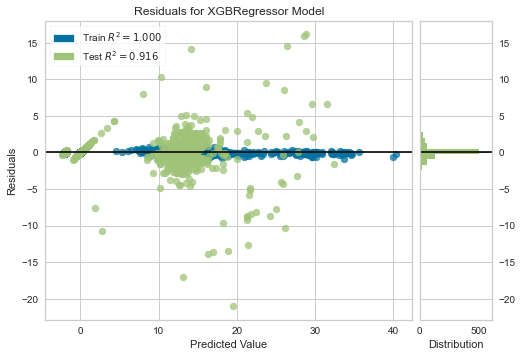

In [123]:
get_scores_for_data(data_cbrt,True)
get_residual_plots(data_cbrt)

In [124]:
data_cbrt.columns

Index(['Year', 'COTTON AREA (1000 ha)', 'COTTON PRODUCTION (1000 tons)',
       'COTTON YIELD (Kg per ha)', 'JANUARY PERCIPITATION (Millimeters)',
       'FEBRUARY PERCIPITATION (Millimeters)',
       'MARCH PERCIPITATION (Millimeters)',
       'APRIL PERCIPITATION (Millimeters)', 'MAY PERCIPITATION (Millimeters)',
       'JUNE PERCIPITATION (Millimeters)',
       ...
       'PHOSPHATE SHARE IN NPK (Percent)',
       'PHOSPHATE PER HA OF NCA (Kg per ha)',
       'PHOSPHATE PER HA OF GCA (Kg per ha)', 'POTASH CONSUMPTION (tons)',
       'POTASH SHARE IN NPK (Percent)', 'POTASH PER HA OF NCA (Kg per ha)',
       'POTASH PER HA OF GCA (Kg per ha)', 'TOTAL CONSUMPTION (tons)',
       'TOTAL PER HA OF NCA (Kg per ha)', 'TOTAL PER HA OF GCA (Kg per ha)'],
      dtype='object', length=101)

In [125]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
x=data_cbrt.drop(columns=['COTTON YIELD (Kg per ha)'])
y=data_cbrt['COTTON YIELD (Kg per ha)']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
param_grid={'max_depth':[3,4,None]}
tree_model=GridSearchCV(DecisionTreeRegressor(random_state=0),cv=5,scoring='neg_mean_squared_error',param_grid=param_grid)
tree_model.fit(x_train,y_train)
train_pred=tree_model.predict(x_train)
test_pred=tree_model.predict(x_test)
new_feature=[]
for i in train_pred:
    new_feature.append(i)
for i in test_pred:
    new_feature.append(i)
print(len(new_feature))
print(data_cbrt.shape)

4705
(4705, 101)


In [126]:
data_cbrt['new_feature']=new_feature

for algorithm LinearRegression(),mse is:2601.0514727361265


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


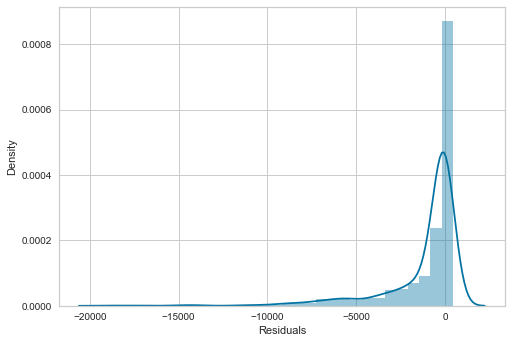

for algorithm Lasso(alpha=0.1),mse is:2560.678087357985


c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.453e+02, tolerance: 2.393e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


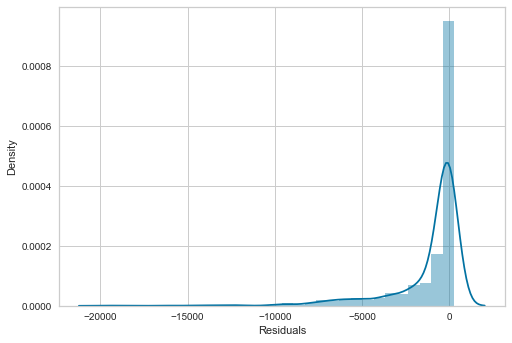

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


for algorithm BayesianRidge(),mse is:2521.7351318890874


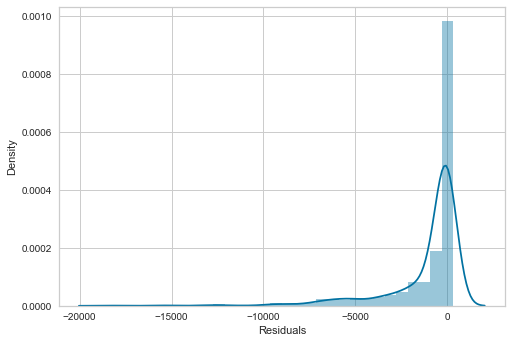

for algorithm RandomForestRegressor(),mse is:3131.517280074318


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


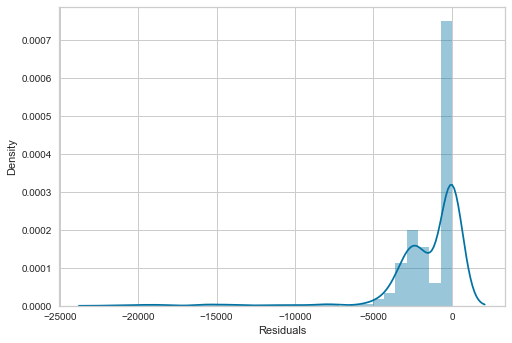

for algorithm XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...),mse is:3657.5624879175584


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


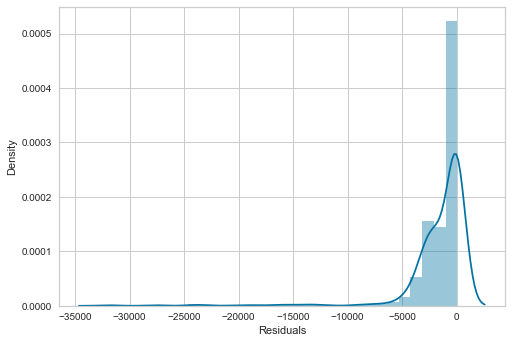

for pipeline Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]),mse is:23338.063499054777
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]),mse is:3099.1507890814246
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                

c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


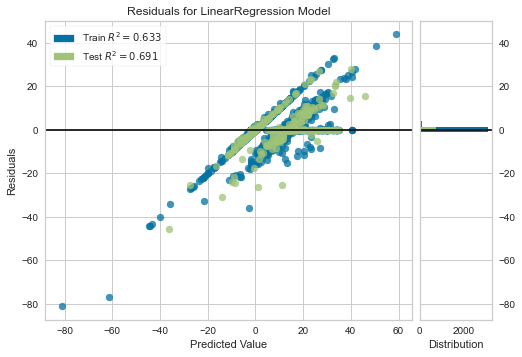

c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


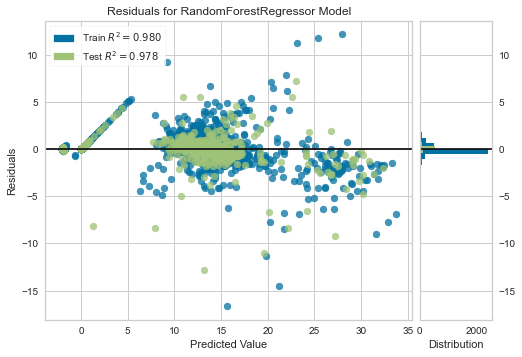

c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


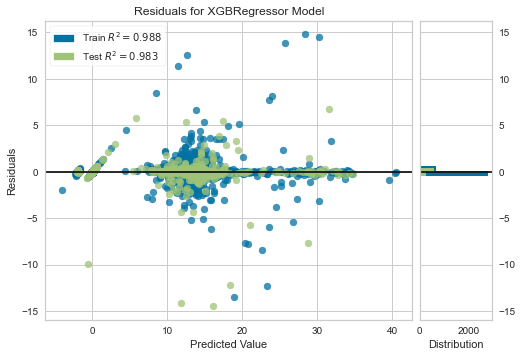

In [127]:
get_scores_for_data(data_cbrt,True)

In [128]:
data_india_test=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/India_test.csv')
data_test=fill_null(data_india_test)

In [129]:
print(data_india_test.shape)
print(data_test.shape)

(2476, 103)
(2476, 101)


In [130]:
def get_predictions_for_data(data,data_test,flag):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    s=BaselineScore(x,y)
    x_test=data_test.drop(columns=['COTTON YIELD (Kg per ha)'])
    s.get_results(0.2,flag)
    results=s.get_predictions(x_test)
    return results


for algorithm LinearRegression(),mse is:2857.7024878381185


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


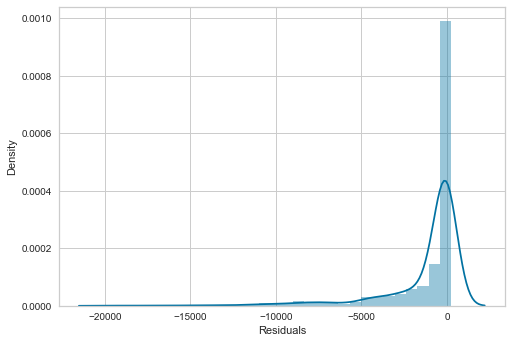

for algorithm Lasso(alpha=0.1),mse is:2781.257527998375


c:\Users\B Pranay\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.139e+03, tolerance: 2.343e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


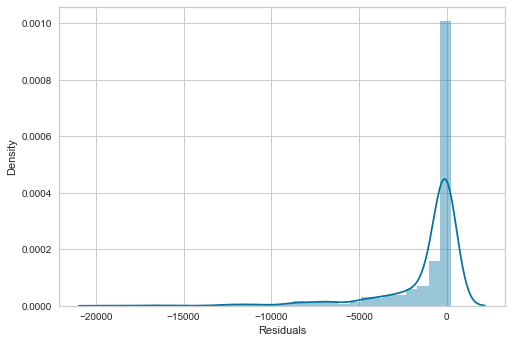

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


for algorithm BayesianRidge(),mse is:2744.24519539203


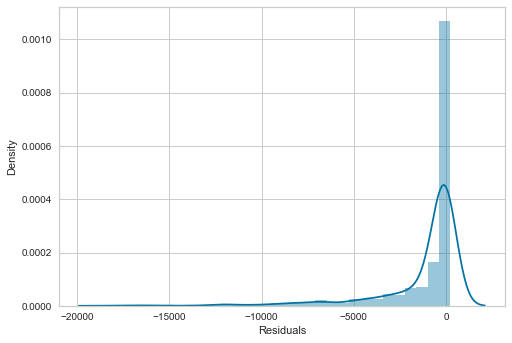

for algorithm RandomForestRegressor(),mse is:3335.9926719143004


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


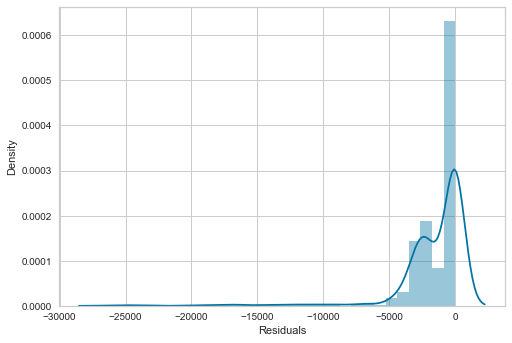

for algorithm XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...),mse is:3620.7738819064084


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


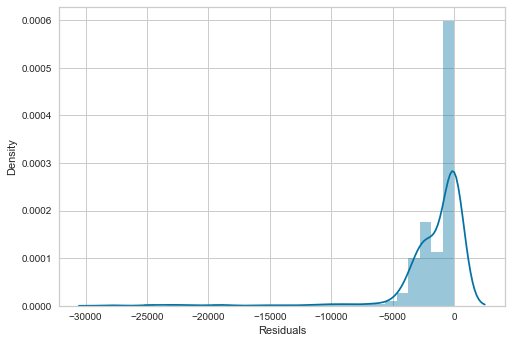

for pipeline Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]),mse is:180490.30982463981
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]),mse is:3347.1356453678704
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                

In [131]:
data_test=data_test.loc[:,important_cols]
data_test[cols_to_norm]=transformer.transform(data_test[cols_to_norm])
x_test0=data_test.drop(columns=['COTTON YIELD (Kg per ha)'])
new_test_feat=tree_model.predict(x_test0)
data_test['new_feature']=new_test_feat
predictions=get_predictions_for_data(data_cbrt,data_test,True)

In [132]:
data_test.shape

(2476, 102)

In [32]:
data_cbrt.shape

(4705, 74)

In [27]:
def xgbalgo(data,data_test):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    ssl=StandardScaler()
    x=ssl.fit_transform(x)
    x_train,x_test,y_train,y_test=train_test_split(x,y)
    model=XGBRegressor()
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    score=np.sqrt(mean_squared_error(y_pred,y_test))
    print(score)
    visualizer=ResidualsPlot(model)
    visualizer.fit(x_train,y_train)
    visualizer.score(x_test,y_test)
    visualizer.show()
    x_test=data_test.drop(columns=['COTTON YIELD (Kg per ha)'])
    x_test=ssl.transform(x_test)
    print(ssl.get_feature_names_out())
    pred=model.predict(x_test)
    return pred
    


In [28]:
#predictions=xgbalgo(data_norm,data_test)

In [33]:
predictions

[array([ 21.18649733,  16.36606035,   7.08505632, ..., -28.52442628,
         -0.81856242,  -3.61645841]),
 array([15.47739419, 15.61600831, 16.03407955, ...,  0.        ,
         0.        ,  0.        ]),
 array([14.890407  , 15.820705  , 16.951202  , ...,  0.03944488,
        -0.0273707 , -0.0794431 ], dtype=float32)]

In [34]:
india_submission=[]
for i in predictions[1]:
    india_submission.append(np.power(i,3))
india_submission

[3707.605612821967,
 3808.1153455899243,
 4122.228882012746,
 4676.584200057333,
 4820.037330817223,
 6325.564903907331,
 3014.350973845857,
 2616.745271043889,
 0.0,
 284.04171775103566,
 0.0,
 0.0,
 0.0,
 0.0065119999999999996,
 897.7292449352354,
 0.0065119999999999996,
 0.0,
 0.0,
 -7.2903470343449355,
 -7.713901774069923,
 -7.7994813830287555,
 -7.550472001352065,
 -7.4169401822493075,
 -7.715712862687276,
 -7.2805651601423085,
 -7.267770602518804,
 -7.128801408701915,
 3964.7878044972094,
 0.091648,
 0.0,
 0.0,
 0.001432,
 3792.1002618381494,
 5949.491878766314,
 4326.674025712458,
 3500.9552482558965,
 6428.894269812575,
 0.0,
 0.0,
 6487.240898394204,
 6409.2661588507835,
 3467.5820449321373,
 3606.860896432187,
 3543.1302350306805,
 3859.6784663769204,
 6894.450756639799,
 4874.89261641967,
 3399.0905542865494,
 3739.115499261293,
 4622.196450581656,
 0.0,
 4571.306883935841,
 0.0,
 0.0,
 3182.8367542143237,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001432,
 7811.7330900485995,
 0.0,
 

In [35]:
india=pd.DataFrame()
india['COTTON YIELD (Kg per ha)']=india_submission

In [36]:
india.tail()

,COTTON YIELD (Kg per ha)
2471,0.0
2472,0.0
2473,0.0
2474,0.0
2475,0.0


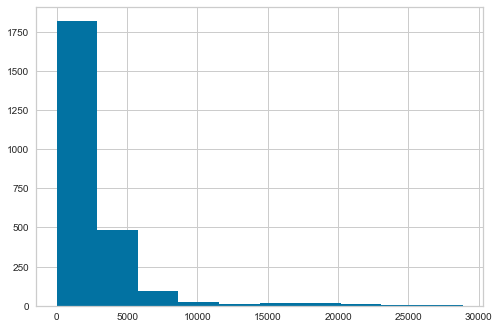

In [37]:
plt.hist(india['COTTON YIELD (Kg per ha)'])
plt.show()

In [38]:
data_usa=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/USA_train.csv')
data_usa.head()

,Year,State,Planted (1000 Acres),Harvested (1000 Acres),Yield (Pounds/ Harvested Area),Average Temperature Value,Average Temperature Anomaly,Maximum Temperature Value,Maximum Temperature Anomaly,Minimum Temperature Value,...,Heating Degree Days Value,Heating Degree Days Anomaly,Palmer Drought Severity Index (PDSI) Value,Palmer Drought Severity Index (PDSI) Anomaly,Palmer Hydrological Drought Index (PHDI) Value,Palmer Hydrological Drought Index (PHDI) Anomaly,Palmer Modified Drought Index (PMDI) Value,Palmer Modified Drought Index (PMDI) Anomaly,Palmer Z-Index Value,Palmer Z-Index Anomaly
0,1975,AL,385,370,406,66.825000,1.566667,75.066667,2.266667,54.566667,...,224.916667,-1.083333,8.161667,6.840833,NaN,4.684167,6.132500,5.821667,4.857500,2.718333
1,1975,NaN,700,680,486,63.875000,2.225000,73.808333,1.208333,52.975000,...,299.250000,8.750000,6.674167,6.331667,5.414167,4.894167,5.098333,3.680000,1.537500,3.382500
2,1975,AZ,NaN,268,1028,61.891667,-0.733333,74.483333,-0.291667,45.283333,...,211.166667,43.416667,0.584167,0.403333,1.584167,0.375000,1.140833,2.805000,3.648333,0.893333
3,1975,CA,900,875,1074,NaN,-0.383333,72.700000,-0.466667,46.825000,...,303.083333,NaN,2.650000,4.479167,1.613333,4.324167,1.405000,2.100833,3.068333,2.322500
4,1975,FL,4,4,347,73.208333,4.133333,83.983333,2.308333,64.408333,...,49.916667,-6.666667,1.191667,1.801667,4.085000,1.762500,2.155000,1.778333,3.239167,3.455833


In [39]:
def get_predictions_for_data_usa(data,data_test,flag):
    x=data.drop(columns=['Yield (Pounds/ Harvested Area)'])
    y=data['Yield (Pounds/ Harvested Area)']
    s2=BaselineScore(x,y)
    x_test=data_test.drop(columns=['Yield (Pounds/ Harvested Area)'])
    s2.get_results(0.2,flag)
    results=s2.get_predictions(x_test)
    return results


In [40]:
def fill_null_usa(data):
    data_copy=data.copy()
    data_copy.drop(columns=['State','Planted (1000 Acres)','Harvested (1000 Acres)'],inplace=True)
    data_copy=data_copy.interpolate(method='linear',limit_direction='forward')
    data_copy=data_copy.fillna(0)
    return data_copy

In [41]:
def get_with_importance_usa(data):
    data_copy=data.copy()
    x=data_copy.drop(columns=['Yield (Pounds/ Harvested Area)'])
    y=data_copy['Yield (Pounds/ Harvested Area)']
    x=ssl.fit_transform(x)
    model=XGBRegressor()
    model.fit(x,y)
    feat_imp=model.feature_importances_
    return feat_imp

In [42]:
data_train_usa=fill_null_usa(data_usa)

In [43]:
data_train_usa['Yield (Pounds/ Harvested Area)'].value_counts()

0      80
737     4
512     4
560     4
628     4
       ..
555     1
789     1
292     1
850     1
541     1
Name: Yield (Pounds/ Harvested Area), Length: 362, dtype: int64

(array([ 82.,  22.,  83., 129., 121.,  63.,  16.,  13.,  23.,   8.]),
 array([   0.,  147.,  294.,  441.,  588.,  735.,  882., 1029., 1176.,
        1323., 1470.]),
 <BarContainer object of 10 artists>)

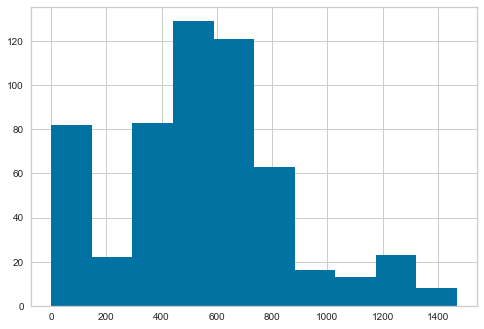

In [44]:
plt.hist(data_train_usa['Yield (Pounds/ Harvested Area)'].values)

In [45]:
imp_feat_usa=get_with_importance_usa(data_train_usa)

In [46]:
imp_feat_usa

array([0.0151106 , 0.01259601, 0.00454263, 0.1132694 , 0.01249384,
       0.18038931, 0.01251113, 0.07413366, 0.01055359, 0.04976277,
       0.01690862, 0.3815012 , 0.02405575, 0.01225741, 0.01342586,
       0.01061762, 0.01075504, 0.01326155, 0.01386773, 0.00685291,
       0.01113337], dtype=float32)

In [47]:
important_cols_usa=[]
for i,j in zip(imp_feat_usa,data_train_usa.columns):
    if(i>=0.0012 and j!='Yield (Pounds/ Harvested Area)'):
        important_cols_usa.append(j)
        print(i,j)

0.015110603 Year
0.0045426344 Average Temperature Value
0.1132694 Average Temperature Anomaly
0.012493837 Maximum Temperature Value
0.18038931 Maximum Temperature Anomaly
0.012511128 Minimum Temperature Value
0.074133664 Minimum Temperature Anomaly
0.010553592 Precipitation Value
0.04976277 Precipitation Anomaly
0.016908618 Cooling Degree Days Value
0.3815012 Cooling Degree Days Anomaly
0.024055745 Heating Degree Days Value
0.01225741 Heating Degree Days Anomaly
0.013425856 Palmer Drought Severity Index (PDSI) Value
0.010617624 Palmer Drought Severity Index (PDSI) Anomaly
0.010755039 Palmer Hydrological Drought Index (PHDI) Value
0.013261554 Palmer Hydrological Drought Index (PHDI) Anomaly
0.013867728 Palmer Modified Drought Index (PMDI) Value
0.006852909 Palmer Modified Drought Index (PMDI) Anomaly
0.011133365 Palmer Z-Index Value


In [48]:
important_cols_usa.append('Yield (Pounds/ Harvested Area)')

In [49]:
from scipy import stats
z_usa=np.abs(stats.zscore(data_train_usa['Yield (Pounds/ Harvested Area)']))
print(z_usa)

0      0.410400
1      0.161693
2      1.523298
3      1.666305
4      0.593822
         ...   
555    0.068361
556    0.690196
557    0.637279
558    0.009293
559    0.214543
Name: Yield (Pounds/ Harvested Area), Length: 560, dtype: float64


In [46]:
outliers_us=np.where(z_usa>2)[0]

In [47]:
len(outliers_us)

29

In [50]:
data_test_usa=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/USA_test.csv')

In [51]:
data_usa_test=fill_null_usa(data_test_usa)


In [57]:
data_train_usa.columns

Index(['Year', 'Average Temperature Value', 'Average Temperature Anomaly',
       'Maximum Temperature Value', 'Maximum Temperature Anomaly',
       'Minimum Temperature Value', 'Minimum Temperature Anomaly',
       'Precipitation Value', 'Precipitation Anomaly',
       'Cooling Degree Days Value', 'Cooling Degree Days Anomaly',
       'Heating Degree Days Value', 'Heating Degree Days Anomaly',
       'Palmer Drought Severity Index (PDSI) Value',
       'Palmer Drought Severity Index (PDSI) Anomaly',
       'Palmer Hydrological Drought Index (PHDI) Value',
       'Palmer Hydrological Drought Index (PHDI) Anomaly',
       'Palmer Modified Drought Index (PMDI) Value',
       'Palmer Modified Drought Index (PMDI) Anomaly', 'Palmer Z-Index Value',
       'Yield (Pounds/ Harvested Area)'],
      dtype='object')

In [51]:
def xgbalgo_usa(data,data_test):
    x=data.drop(columns=['Yield (Pounds/ Harvested Area)'])
    y=data['Yield (Pounds/ Harvested Area)']
    x_train,x_test,y_train,y_test=train_test_split(x,y)
    model=XGBRegressor()
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    score=np.sqrt(mean_squared_error(y_pred,y_test))
    print(score)
    visualizer=ResidualsPlot(model)
    visualizer.fit(x_train,y_train)
    visualizer.score(x_test,y_test)
    visualizer.show()
    x_test=data_test.drop(columns=['Yield (Pounds/ Harvested Area)'])
    pred=model.predict(x_test)
    return pred
    


In [78]:
data_train_usa=data_train_usa.loc[:,important_cols_usa]
data_usa_test=data_usa_test.loc[:,important_cols_usa]
print(data_train_usa.shape)
print(data_usa_test.shape)
#usa_submission=xgbalgo_usa(data_train_usa,data_usa_test)
#usa_submission=get_predictions_for_data_usa(data_train_usa,data_usa_test,False)

(560, 21)
(400, 21)


In [79]:
tree_model2=GridSearchCV(DecisionTreeRegressor(random_state=0),cv=5,scoring='neg_mean_squared_error',param_grid=param_grid)
x=data_train_usa.drop(columns=['Yield (Pounds/ Harvested Area)'])
y=data_train_usa['Yield (Pounds/ Harvested Area)']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
tree_model2.fit(x_train,y_train)
train_pred=tree_model2.predict(x_train)
test_pred=tree_model2.predict(x_test)
new_feat_train_usa=[]
for i in train_pred:
    new_feat_train_usa.append(i)
for i in test_pred:
    new_feat_train_usa.append(i)
data_train_usa['new_feature']=new_feat_train_usa
x_test2=data_usa_test.drop(columns=['Yield (Pounds/ Harvested Area)'])
new_feat_test_pred=tree_model2.predict(x_test2)
data_usa_test['new_feature']=new_feat_test_pred

In [80]:
print(data_train_usa.shape)
print(data_usa_test.shape)

(560, 22)
(400, 22)


for algorithm LinearRegression(),mse is:2.655372822581489


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


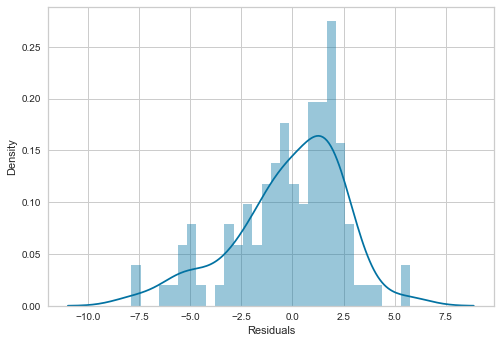

for algorithm Lasso(alpha=0.1),mse is:2.595302100146482


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


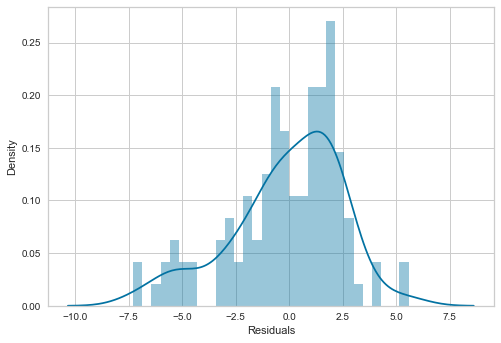

for algorithm BayesianRidge(),mse is:2.604818096560205


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


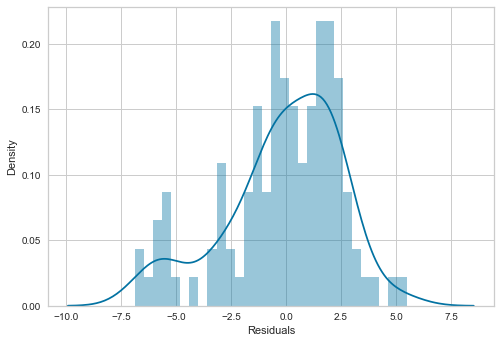

for algorithm RandomForestRegressor(),mse is:2.112505198058121


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


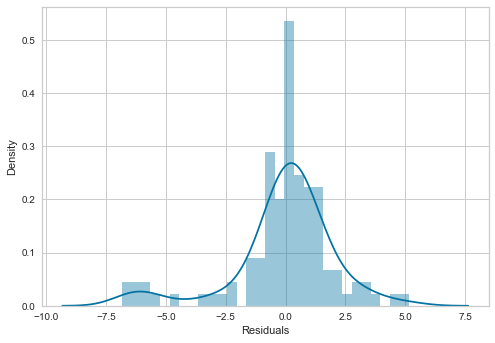

for algorithm XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...),mse is:2.0371774552472113


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


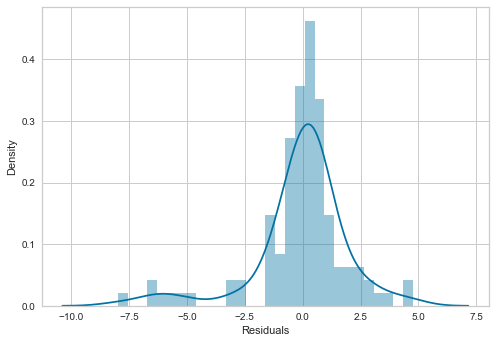

for pipeline Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]),mse is:3.334171874844171
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]),mse is:2.143613644414032
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                  

In [82]:
usa_submission=get_predictions_for_data_usa(data_train_usa,data_usa_test,False)

In [98]:
len(usa_submission)

3

In [99]:
usa_submissions=pd.DataFrame()
usa=[]
for i in usa_submission[2]:
    usa.append(i)

In [100]:
usa_submissions['Yield (Pounds/ Harvested Area)']=usa

In [101]:
usa_submissions.tail()

,Yield (Pounds/ Harvested Area)
395,7.756042
396,8.804686
397,8.708528
398,8.410641
399,6.634048


In [102]:
data_test_usa.shape

(400, 25)

In [103]:
len(usa)

400

In [104]:
commodity=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/USA_Commodity_prices.csv')

In [105]:
# Convert the 'Year' column to numeric type if it's not already
commodity['Year'] = pd.to_numeric(commodity['Year'])

# Select the rows between the years 2003 and 2022
submission_commodity = commodity[(commodity['Year'] >= 2003) & (commodity['Year'] <= 2022)]


In [106]:
submission_commodity=submission_commodity["Cotton_Price[Dollar/ton]"]

In [107]:
submission_india=india['COTTON YIELD (Kg per ha)']
submission_usa=usa_submissions['Yield (Pounds/ Harvested Area)']

In [108]:
final_submissions=pd.concat([submission_usa,submission_india,submission_commodity],axis=1)

In [109]:
final_submissions.tail()

,Yield (Pounds/ Harvested Area),COTTON YIELD (Kg per ha),Cotton_Price[Dollar/ton]
2471,NaN,0.0,NaN
2472,NaN,0.0,NaN
2473,NaN,0.0,NaN
2474,NaN,0.0,NaN
2475,NaN,0.0,NaN


In [110]:
final_submissions=final_submissions.fillna(0)

In [111]:
final_submissions.head()

,Yield (Pounds/ Harvested Area),COTTON YIELD (Kg per ha),Cotton_Price[Dollar/ton]
0,8.607878,3707.605613,0.0
1,8.593782,3808.115346,0.0
2,9.683056,4122.228882,0.0
3,9.680159,4676.584200,0.0
4,8.128520,4820.037331,0.0


In [112]:
final_submissions.head()

,Yield (Pounds/ Harvested Area),COTTON YIELD (Kg per ha),Cotton_Price[Dollar/ton]
0,8.607878,3707.605613,0.0
1,8.593782,3808.115346,0.0
2,9.683056,4122.228882,0.0
3,9.680159,4676.584200,0.0
4,8.128520,4820.037331,0.0


In [113]:
final_submissions.to_csv("dectree3.csv",index=False)

In [68]:
data_norm.tail()

,COTTON AREA (1000 ha),COTTON PRODUCTION (1000 tons),APRIL PERCIPITATION (Millimeters),MAY PERCIPITATION (Millimeters),JUNE PERCIPITATION (Millimeters),SEPTEMBER PERCIPITATION (Millimeters),OCTOBER PERCIPITATION (Millimeters),DECEMBER PERCIPITATION (Millimeters),JANUARY MINIMUM (Centigrate),FEBRUARY MINIMUM (Centigrate),...,NITROGEN PER HA OF NCA (Kg per ha),NITROGEN PER HA OF GCA (Kg per ha),PHOSPHATE CONSUMPTION (tons),PHOSPHATE PER HA OF NCA (Kg per ha),PHOSPHATE PER HA OF GCA (Kg per ha),POTASH CONSUMPTION (tons),POTASH SHARE IN NPK (Percent),POTASH PER HA OF NCA (Kg per ha),TOTAL CONSUMPTION (tons),COTTON YIELD (Kg per ha)
4700,0.0,0.0,284.72,427.76,584.62,444.49,101.25,3.505,12.73,18.71,...,60.46,36.43,13499.0,44.20,25.52,11421.0,27.030,35.01,43874.0,2.302585
4701,0.0,0.0,288.60,352.63,534.90,427.48,82.27,7.010,12.85,17.00,...,191.52,143.92,8841.0,64.10,48.93,6477.0,26.425,48.47,42436.0,2.302585
4702,0.0,0.0,48.28,112.66,176.42,234.24,72.54,4.450,11.75,19.03,...,244.88,129.86,22484.0,108.35,58.66,20547.0,25.820,99.19,94166.0,2.302585
4703,0.0,0.0,248.95,442.75,518.50,331.44,101.72,3.370,15.42,19.46,...,73.35,39.87,9727.0,42.16,22.97,8003.0,25.740,33.22,35189.0,2.302585
4704,0.0,0.0,18.69,94.11,161.88,300.74,59.91,1.010,16.02,21.11,...,29.03,22.64,4163.0,14.41,15.59,8003.0,13.530,9.51,13637.0,2.302585


In [84]:
len(important_cols)

73

In [101]:
#for i in important_cols:
    #sns.distplot(data=data_norm)
    #plt.title(i)
    #plt.show()

In [69]:
data_norm2=data_norm.copy()

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


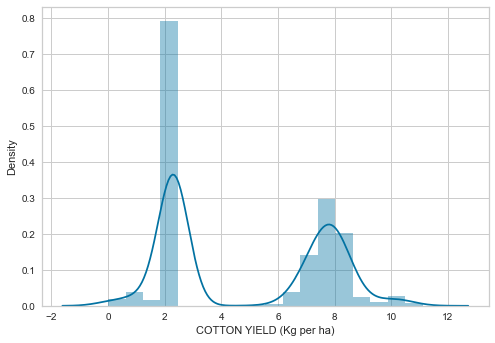

In [70]:
sns.distplot(data_norm2['COTTON YIELD (Kg per ha)'])
plt.show()

In [74]:
cols_to_norm=['COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)','MAY PERCIPITATION (Millimeters)','OCTOBER PERCIPITATION (Millimeters)','DECEMBER PERCIPITATION (Millimeters)','JUNE WATER DEFICIT (Millimeters)','AUGUST WATER DEFICIT (Millimeters)','MAY ACTUAL (Millimeters)','FOREST AREA (1000 ha)','BARREN AND UNCULTIVABLE LAND AREA (1000 ha)','CULTIVABLE WASTE LAND AREA (1000 ha)','OTHER FALLOW AREA (1000 ha)','NITROGEN CONSUMPTION (tons)','POTASH CONSUMPTION (tons)','COTTON YIELD (Kg per ha)']

In [75]:
data_cbrt=data_train.copy()
data_cbrt=data_cbrt.loc[:,important_cols]

In [76]:
len(data_cbrt.columns)

73

In [77]:
cols_to_norm=['COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)','MAY PERCIPITATION (Millimeters)','OCTOBER PERCIPITATION (Millimeters)','DECEMBER PERCIPITATION (Millimeters)','JUNE WATER DEFICIT (Millimeters)','AUGUST WATER DEFICIT (Millimeters)','MAY ACTUAL (Millimeters)','FOREST AREA (1000 ha)','BARREN AND UNCULTIVABLE LAND AREA (1000 ha)','CULTIVABLE WASTE LAND AREA (1000 ha)','OTHER FALLOW AREA (1000 ha)','NITROGEN CONSUMPTION (tons)','POTASH CONSUMPTION (tons)','COTTON YIELD (Kg per ha)']
from sklearn.preprocessing import FunctionTransformer
transformer=FunctionTransformer(np.cbrt)
data_cbrt[cols_to_norm]=transformer.transform(data_cbrt[cols_to_norm])

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


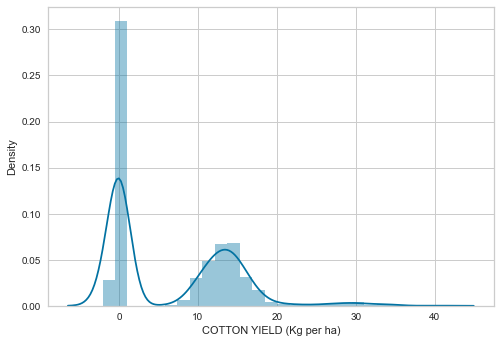

In [78]:
sns.distplot(data_cbrt['COTTON YIELD (Kg per ha)'])
plt.show()

In [97]:
data_exp=data_train.copy()
data_exp=data_exp.loc[:,important_cols]
transformer_exp=FunctionTransformer(lambda x:np.power(x,0.05))
data_exp[cols_to_norm]=transformer_exp.transform(data_exp[cols_to_norm])

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


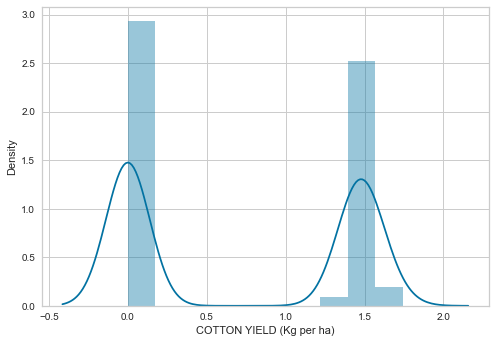

In [98]:
sns.distplot(data_exp['COTTON YIELD (Kg per ha)'])
plt.show()

In [99]:
print(data_exp.shape)
print(data_train.shape)

(4705, 73)
(4705, 101)


In [100]:
data_exp['COTTON YIELD (Kg per ha)'].values

array([0.        , 1.50017445, 1.53004401, ..., 0.        , 0.        ,
       0.        ])

In [101]:
data_train['COTTON YIELD (Kg per ha)'].values

array([   0, 3333, 4944, ...,    0,    0,    0], dtype=int64)

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


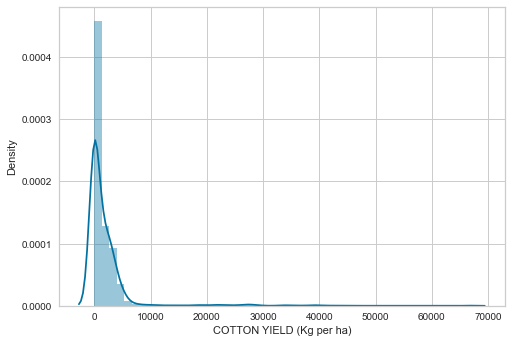

In [102]:
sns.distplot(data_train['COTTON YIELD (Kg per ha)'])
plt.show()

In [109]:
data_test_cbrt=data_test.copy()
data_test_cbrt[cols_to_norm]=transformer.transform(data_test_cbrt[cols_to_norm])

In [110]:
data_test.shape

(2476, 73)

for algorithm LinearRegression(),mse is:2962.6416450995603


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


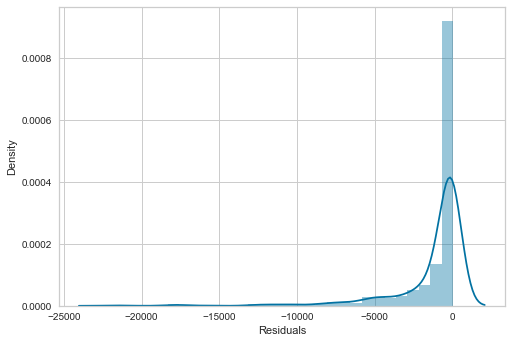

for algorithm Lasso(alpha=0.1),mse is:2909.088108763085


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


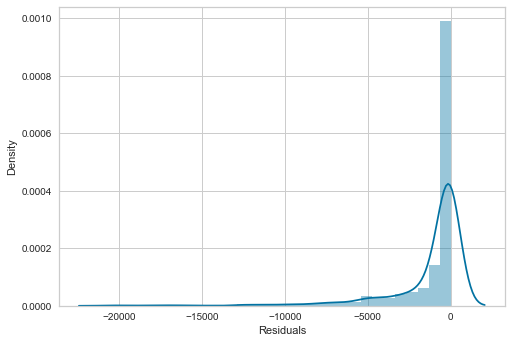

for algorithm BayesianRidge(),mse is:2896.4561130625907


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


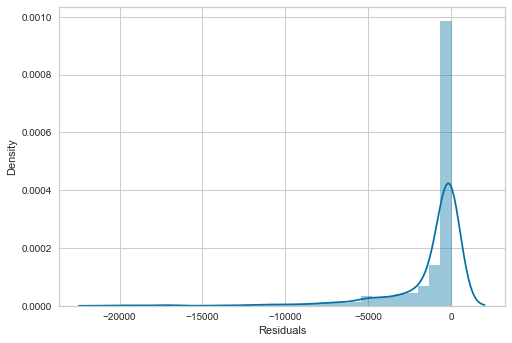

for algorithm RandomForestRegressor(),mse is:3431.808117314155


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


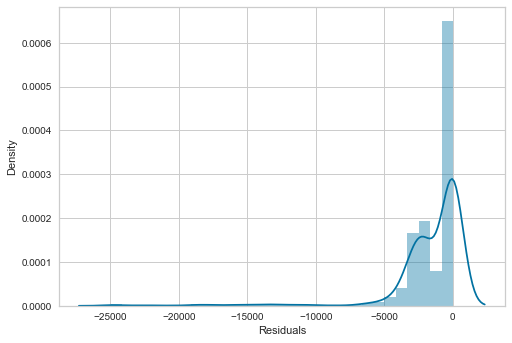

for algorithm XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...),mse is:3776.9680374609097


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


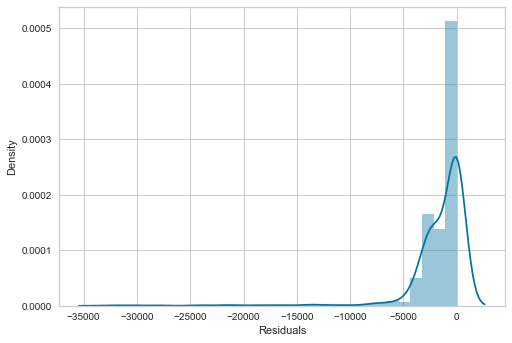

for pipeline Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]),mse is:7448.818670470377
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]),mse is:3561.0349463421703
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                 

In [114]:
predictions_exp=get_predictions_for_data(data_cbrt,data_test_cbrt,True)

for algorithm LinearRegression(),mse is:2730.315477980483


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


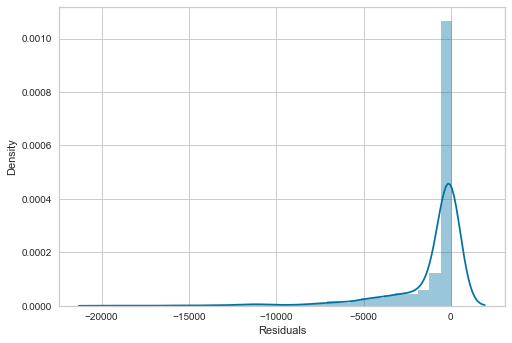

for algorithm Lasso(alpha=0.1),mse is:2682.958606445286


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


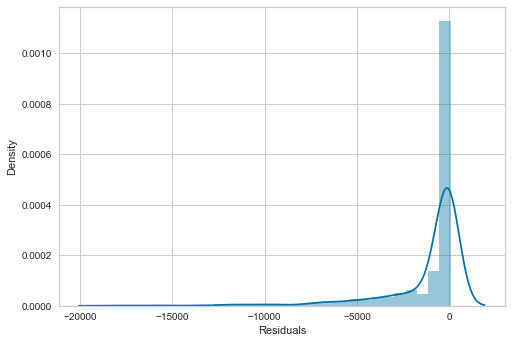

for algorithm BayesianRidge(),mse is:2661.3547814088483


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


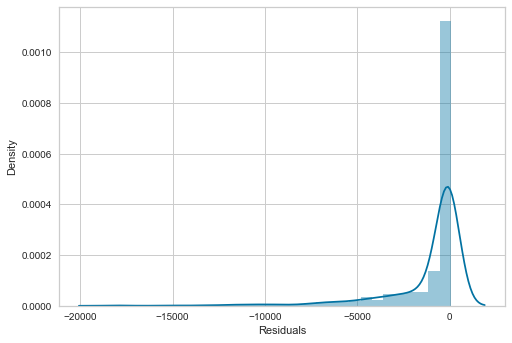

for algorithm RandomForestRegressor(),mse is:3526.6908444015116


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


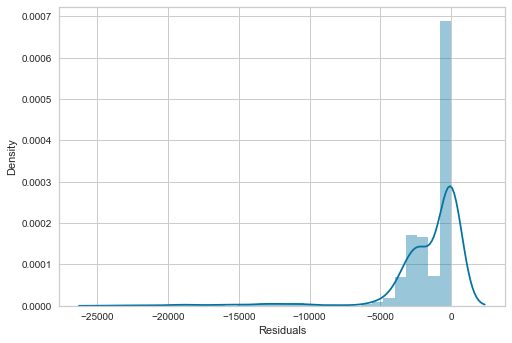

for algorithm XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...),mse is:3868.593325711434


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


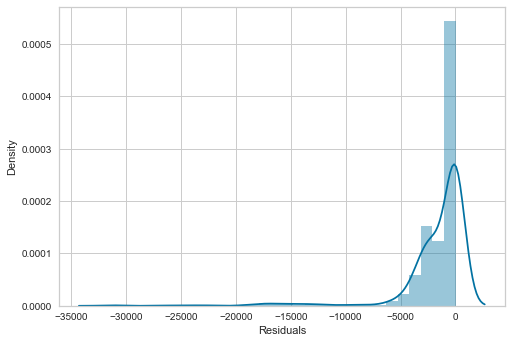

for pipeline Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]),mse is:12445.882272426752
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]),mse is:3485.6386855151395
for pipeline Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                

In [126]:
predictions_cbrt2=get_predictions_for_data(data_cbrt,data_test_cbrt,True)

In [127]:
predictions_cbrt2

[array([ 34.36033173,  23.55425176,   7.94280999, ..., -17.21841991,
          7.97597885,  -2.21512278]),
 array([16.65458849, 16.37293187, 16.34263194, ...,  0.        ,
         0.        ,  0.        ]),
 array([15.4517    , 14.331542  , 15.376646  , ...,  0.03483398,
        -0.04102715, -0.08348465], dtype=float32),
 array([ 8.29787093,  8.83407224, 11.04715367, ..., -0.74243031,
        -1.32821674, -0.92868058]),
 array([ 8.27157758,  8.17460401, 11.08898319, ..., -0.1772538 ,
        -1.23705045, -0.59214006]),
 array([ 7.53639367,  8.143635  , 10.80680778, ..., -0.30992747,
        -0.82140334, -0.58996677]),
 array([15.87508845, 16.46792447, 16.27607202, ...,  0.        ,
         0.        ,  0.        ]),
 array([15.4517    , 14.331542  , 15.376646  , ...,  0.03483398,
        -0.04102715, -0.08348465], dtype=float32)]

In [129]:
india_submission3=[]
for i in predictions_cbrt2[5]:
    india_submission3.append(np.power(i,3))
india_submission3


[428.0462804864417,
 540.0760275876087,
 1262.0956785825103,
 969.9048161022099,
 5639.960253907876,
 16857.997856619037,
 2849.051083598811,
 2522.3079929132687,
 854.1265929653487,
 15.682632759164598,
 -0.014867613603481836,
 -0.003991216626215364,
 3.010615357785786,
 4.366920610433705,
 159.10149435405816,
 1.2988986663404931,
 3.124354281368426,
 0.37418884391644686,
 0.08587048102749918,
 -3.1902308062730973,
 -4.608122610461636,
 0.25779344822937456,
 -0.7217900791488198,
 1.8577139649634506,
 4.61537147347077,
 0.6472477565336191,
 11.312269565794173,
 98.0254009118096,
 121.06517970707364,
 5.101621851358913,
 14.204762787705192,
 16.345578344980446,
 5417.1164970412165,
 10244.546542752625,
 1668.9637610633322,
 3379.111702911422,
 19976.65594549965,
 3.1457560668792124,
 73.05319833159604,
 10684.282232796375,
 3529.342965189729,
 396.8126922202308,
 8661.816879881002,
 2548.1470988520705,
 1277.9080753502444,
 13812.561956513993,
 4971.192846147259,
 535.8166469941102,
 17

In [130]:
final_submissions_cbrt=final_submissions.copy()
final_submissions_cbrt['COTTON YIELD (Kg per ha)']=india_submission3

In [131]:
final_submissions_cbrt.head()

,Yield (Pounds/ Harvested Area),COTTON YIELD (Kg per ha),Cotton_Price[Dollar/ton]
0,684.130676,428.046280,0.0
1,725.272400,540.076028,0.0
2,949.523926,1262.095679,0.0
3,1134.204590,969.904816,0.0
4,732.629578,5639.960254,0.0


In [132]:
final_submissions.head()

,Yield (Pounds/ Harvested Area),COTTON YIELD (Kg per ha),Cotton_Price[Dollar/ton]
0,684.130676,3325.856934,0.0
1,725.272400,3276.163330,0.0
2,949.523926,3678.286621,0.0
3,1134.204590,4742.204590,0.0
4,732.629578,4687.439941,0.0


In [133]:
final_submissions_cbrt.to_csv("cbrt2_submit.csv",index=False)